# Photonic Quantum Fourier Transform Remote Simulation

### Prerequisites
- Install Perceval using ```pip install perceval-quandela```
- Go to https://cloud.quandela.com/webide/ and create an account to get a token API key

In [ ]:
# inmports
import numpy as np
import matplotlib.pyplot as plt

import perceval as pcvl
import perceval.components as comp
from perceval import Processor, BasicState
from perceval.algorithm import Sampler
pcvl.__version__

'1.1.0'

In [4]:
def bitstring_to_fock(bitstring):
    # if the parameter is a string, make it a list of ints
    if isinstance(bitstring, str):
        bits = [int(b) for b in bitstring]
    else:
        bits = list(bitstring)

    n = len(bits)
    N = 2 ** n
    index = int("".join(str(b) for b in bits), 2)

    occ = [0] * N
    occ[index] = 1

    # basic state is fock state w/ perceval
    return BasicState(occ)


In [5]:
# qft matrix
def qft_matrix(num_qubits):
    N = 2 ** num_qubits
    omega = np.exp(2j * np.pi / N)
    matrix = np.array([[omega ** (k * l) for l in range(N)] for k in range (N)], dtype = complex) / np.sqrt(N)

    return pcvl.Matrix(matrix)

In [6]:
# unitary of the qft
def qft_unitary_component(num_qubits):
    U = qft_matrix(num_qubits)
    qft_unit = comp.Unitary(U = U)
    return qft_unit

In [7]:
def photonic_qft(num_qubits, bitstring, shots = 1024):
    N = 2 ** num_qubits

    qft_unitary = qft_unitary_component(num_qubits)

    processor = Processor("SLOS", qft_unitary)

    input_state = bitstring_to_fock(bitstring)
    processor.with_input(input_state)
    processor.min_detected_photons_filter(1)

    sampler = Sampler(processor)
    results = sampler.sample_count(shots)["results"]

    print("QFT unitary on", N, "modes:")
    pcvl.pdisplay(qft_unitary.U)

    return results


In [8]:
def normalize_counts(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

In [9]:
def plot_results(counts, title = "QFT output"):
    probabilities = normalize_counts(counts)
    states = list(probabilities.keys())
    prob_values = [float(v) for v in probabilities.values()]

    labels = [str(s) for s in states]

    plt.figure()
    plt.bar(range(len(states)), prob_values)
    plt.xticks(range(len(states)), labels, rotation = 45)
    plt.ylabel("Probability")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_bitstring_probabilities(counts, num_qubits, title = "QFT Output"):
    total = sum(counts.values())
    data = []

    # bs = basis state = fock state
    for bs, c in counts.items():
        occ = list(bs)
        i = occ.index(1)
        bitstr = format(i, f"0{num_qubits}b")
        prob = c / total
        data.append((i, bitstr, prob))

    data.sort(key = lambda t: t[0])

    x = [t[1] for t in data]
    y = [t[2] for t in data]

    plt.figure(figsize = (12, 5))
    plt.bar(x, y)
    plt.xticks(rotation = 60)
    plt.ylabel("Probability")
    plt.title(title)
    plt.ylim(0, 1.0)
    plt.tight_layout()

In [11]:
def fock_to_index(bs):
    occ = list(bs)
    return occ.index(1)

def plot_counts(counts, num_qubits, title = "Photnic QFT Result Count Distribution"):
    data = []
    for bs, c in counts.items():
        i = fock_to_index(bs)
        bitstr = format(i, f"0{num_qubits}b")
        data.append((i, bitstr, c))

    data.sort(key = lambda t: t[0])

    indices = [t[0] for t in data]
    bitlabels = [t[1] for t in data]
    counts = [t[2] for t in data]

    plt.figure(figsize = (10, 5))
    plt.bar(indices, counts)
    plt.xticks(indices, bitlabels, rotation = 60, ha = "right")
    plt.xlabel("Bitstring |x⟩")
    plt.ylabel("Counts")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Setting Up Remote Simulation

In [ ]:
# set remote config token
from perceval import RemoteProcessor, NoiseModel, RemoteConfig
from perceval.algorithm import Sampler

# put api key here
API_KEY = ""
REMOTE_PLATFORM = "sim:belenos"

remote_config = RemoteConfig()
remote_config.set_token(API_KEY)
remote_config.save()
remote_simulator = RemoteProcessor(REMOTE_PLATFORM) 

def qft_photonic_remote(num_qubits, bitstring, shots = 1024, platform = REMOTE_PLATFORM, api_key = API_KEY, use_noise=True):
    U = qft_matrix(num_qubits)
    qft_unitary = pcvl.components.Unitary(U)

    # noise model
    noise = None
    if use_noise:
        noise = NoiseModel(transmittance = 0.1, indistinguishability = 0.95, g2 = 0.01)

    processor = RemoteProcessor(platform, api_key, noise = noise)

    try:
        processor.set_circuit(qft_unitary)
    except AttributeError:
        processor.add(0, qft_unitary)

    input_state = bitstring_to_fock(bitstring)
    processor.with_input(input_state)
    processor.min_detected_photons_filter(1)

    sampler = Sampler(processor, max_shots_per_call = shots)
    results = sampler.sample_count(shots)["results"]

    return results

In [ ]:
# remote simulation with 2 qubits
results_remote = qft_photonic_remote(2, "00", shots = 1024)
plot_bitstring_probabilities(results_remote, 2, "Remote Simulation of Photonic QFT with Input |00>")
plot_counts(results_remote, 2, "Counts from Remote Photonic Simulation")

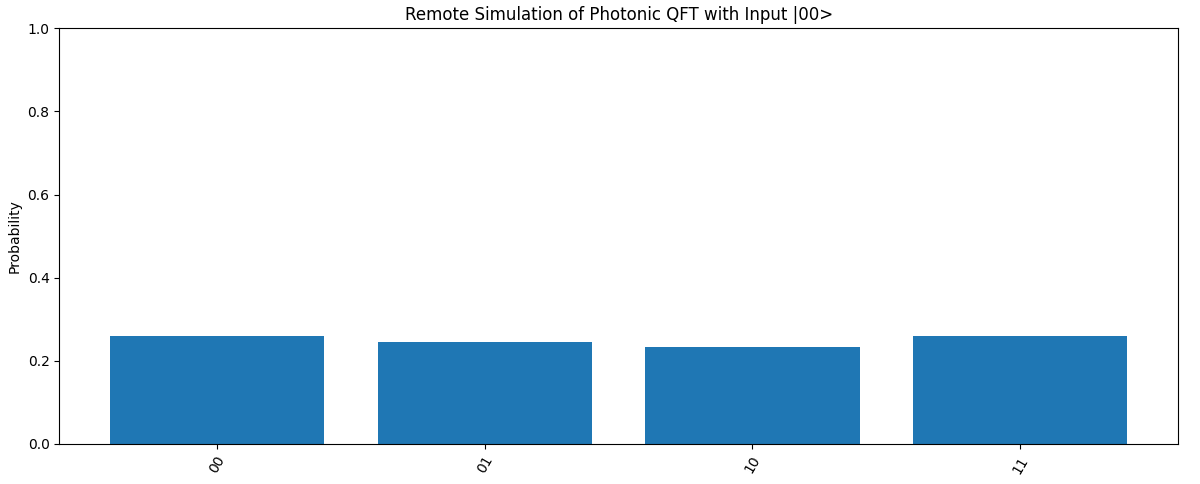

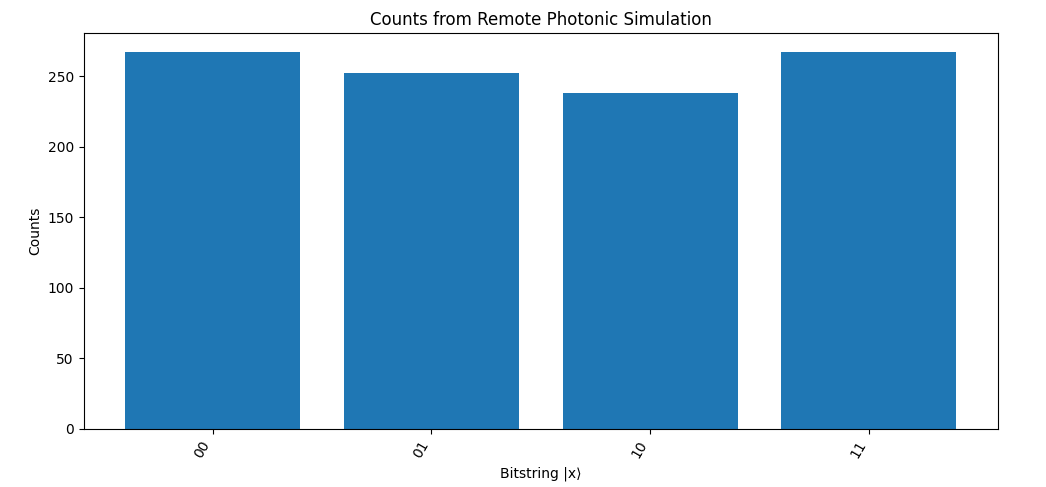

In [ ]:
# remote simulation with 3 qubits
results_remote = qft_photonic_remote(3, "000", shots = 1024)
plot_bitstring_probabilities(results_remote, 3, "Remote Simulation of Photonic QFT with Input |000>")
plot_counts(results_remote, 3, "Counts from Remote Photonic Simulation")

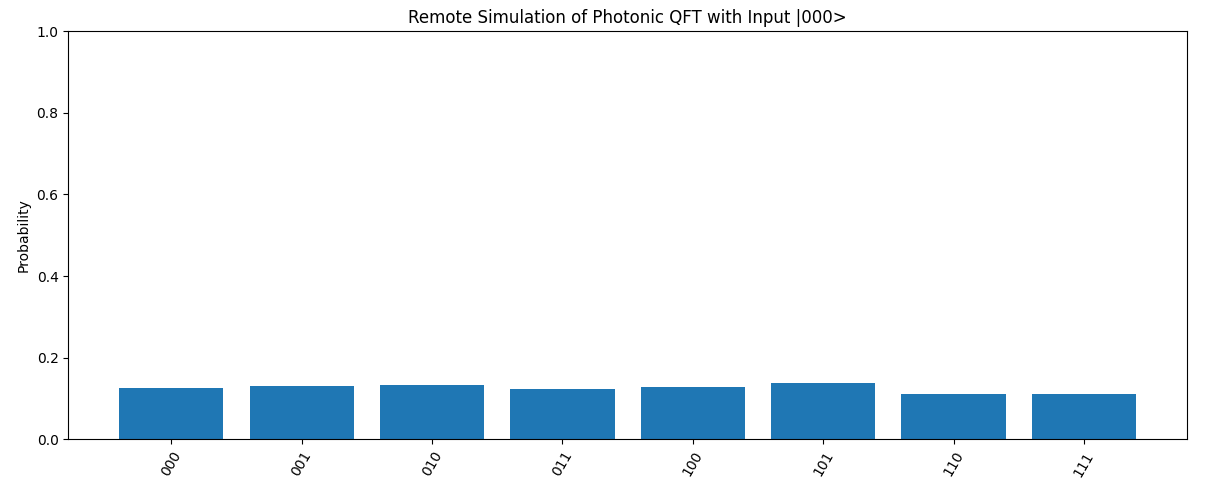

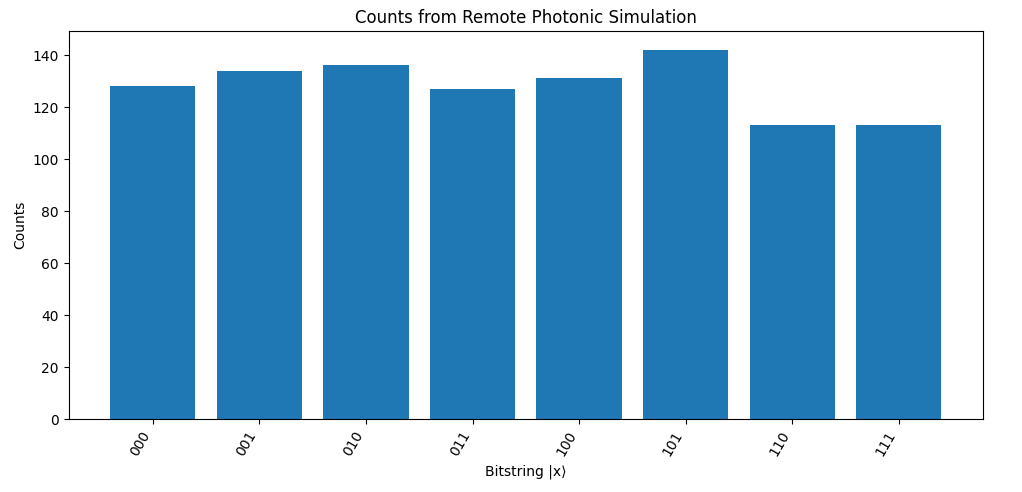

In [ ]:
# remote simulation with 4 qubits
results_remote = qft_photonic_remote(4, "0000", shots = 1024)
plot_bitstring_probabilities(results_remote, 4, "Remote Simulation of Photonic QFT with Input |0000>")
plot_counts(results_remote, 4, "Counts from Remote Photonic Simulation")

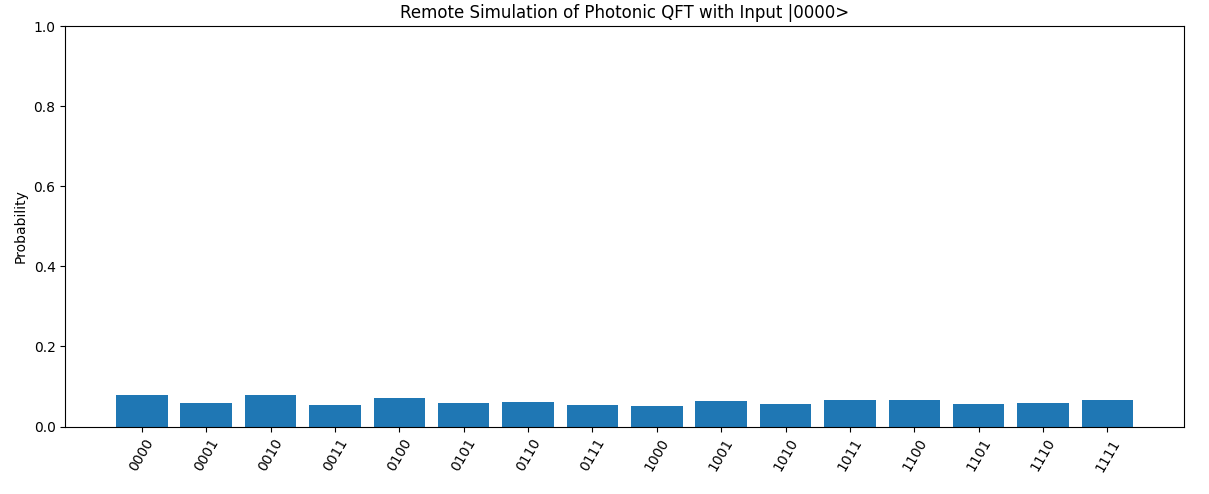

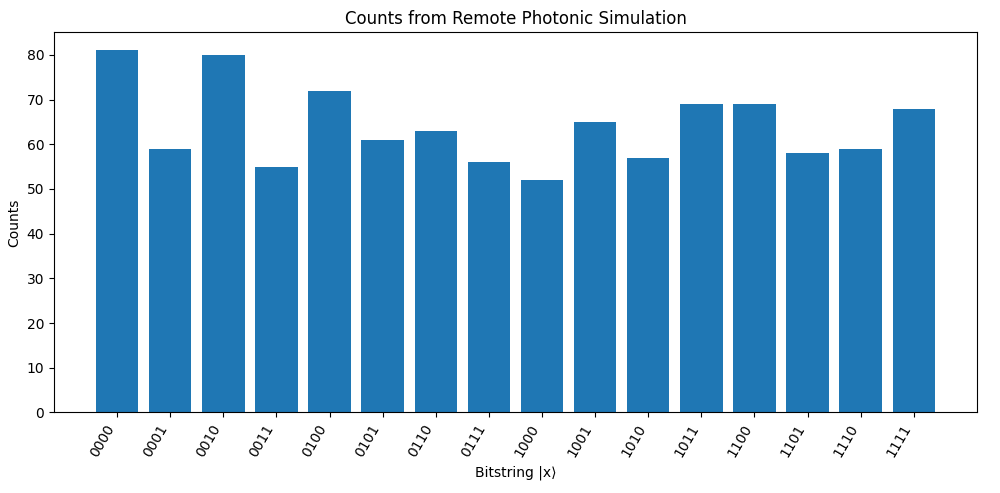